In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re
import torch
import torch.nn as nn
from scipy.optimize import curve_fit
import os
import copy
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
filename = '../data/ple_chirality/BachiloAssign.dat'

# カイラリティとPLEピークデータの読み込み

In [3]:
chiraldata = []
with open(filename, 'r') as f:
    match_pattern = r'^\s*(#.*|)$'
    line = f.readline()
    while line:
        match = re.match(match_pattern, line)
        if not match:
            chiraldata.append([float(x) for x in line.split()])

            # Convert the first two columns to integers
            chiraldata[-1][0] = int(chiraldata[-1][0])
            chiraldata[-1][1] = int(chiraldata[-1][1])
            ###########################################

            # add wavelength column
            chiraldata[-1].append(1240/chiraldata[-1][3])
            chiraldata[-1].append(1240/chiraldata[-1][4])
        line = f.readline()

print(chiraldata)

[[5, 4, 0.62, 1.488, 2.567, 26.32950349, 1.725134409, 833.3333333333334, 483.0541488118426], [6, 4, 0.69, 1.42, 2.134, 23.41322445, 1.502816901, 873.2394366197184, 581.0684161199625], [9, 1, 0.76, 1.359, 1.789, 5.208719103, 1.316409124, 912.4356144223694, 693.1246506428173], [8, 3, 0.78, 1.302, 1.87, 15.2953443, 1.43625192, 952.3809523809523, 663.1016042780748], [6, 5, 0.76, 1.272, 2.187, 26.9955084, 1.719339623, 974.8427672955975, 566.9867398262461], [7, 5, 0.83, 1.212, 1.925, 24.50363346, 1.588283828, 1023.1023102310231, 644.1558441558442], [10, 2, 0.88, 1.177, 1.689, 8.948275565, 1.435004248, 1053.5259133389975, 734.1622261693309], [9, 4, 0.92, 1.126, 1.722, 17.4801702, 1.529307282, 1101.2433392539965, 720.0929152148665], [8, 4, 0.84, 1.114, 2.112, 19.10660535, 1.895870736, 1113.1059245960503, 587.1212121212121], [7, 6, 0.89, 1.105, 1.916, 27.4570761, 1.733936652, 1122.1719457013576, 647.1816283924844], [9, 2, 0.81, 1.088, 2.25, 9.826429816, 2.068014706, 1139.705882352941, 551.11111

chiaraldata\
0 - n\
1 - m\
2 - dt\
3 - E11\
4 - E22\
5 - theta\
6 - E22/E11\
7 - PLwavelength\
8 - ExciteWavelength\

# 実際に取れたPLデータの読み込み

In [4]:
data_dir  = '../data/pldata'

In [5]:
rawdatadict = {}
for filename in os.listdir(data_dir):
    exictelength = filename.split('_')[0]
    rawdatadict[exictelength] = []
    with open(os.path.join(data_dir, filename), 'r') as f:
        match_pattern = r'^\s*(#.*|)$'
        line = f.readline()
        while line:
            match = re.match(match_pattern, line)
            if not match:
                rawdatadict[exictelength].append([float(x) for x in line.split(',')])
            line = f.readline()

In [6]:
myxticks = []
myyticks = [int(key) for key in rawdatadict.keys()]
myyticks = myyticks[::-1]

for slice in rawdatadict.values():
    for x in slice:
        myxticks.append(int(x[0]))
    break
print(myxticks)
print(myyticks)

[941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 11

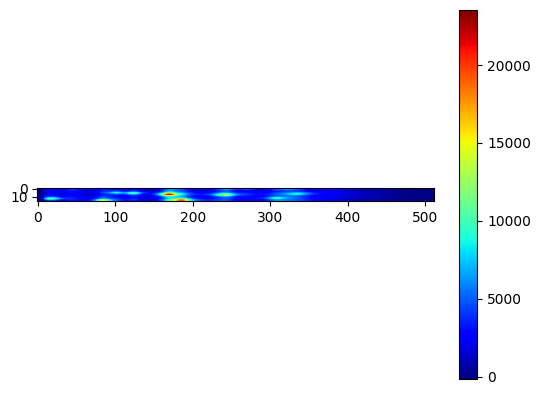

In [7]:
d1_data = []
for key in rawdatadict:
    temp = []
    for data in rawdatadict[key]:
        temp.append(data[1])
    d1_data.append(temp)
d1_datal = d1_data[::-1]#PLEマップの原点は左下．画像の原点は左上．
d1_data = torch.tensor(d1_datal)
plt.imshow(d1_data, cmap='jet')
plt.colorbar()
plt.show()



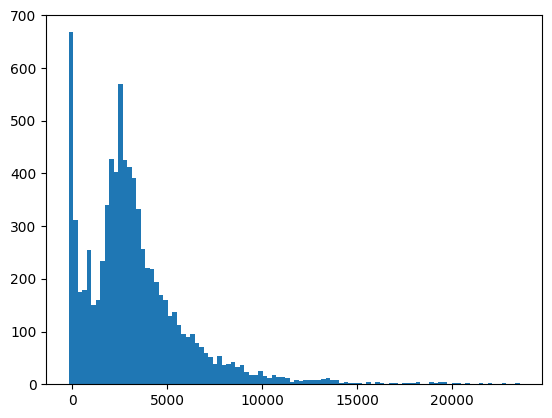

In [8]:
flatten_d1data = d1_data.flatten()
plt.hist(flatten_d1data, bins=100)
plt.show()

In [9]:
def plot10x(data: torch.Tensor) -> None:
    pltdata = []
    for d in data:
        for _ in range(10):
            pltdata.append(d)
    plt.imshow(pltdata, cmap='jet')
    plt.colorbar()
    plt.show()

torch.Size([160, 512])


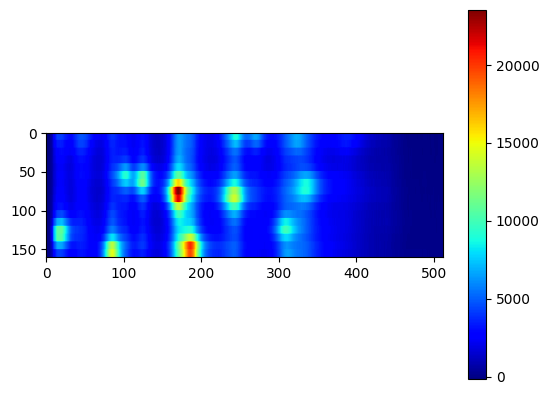

In [10]:
d2_data = []
for d1slice in d1_datal:
    for _ in range(10):
        d2_data.append(d1slice)

d2_data = torch.tensor(d2_data)
print(d2_data.shape)
plot10x(d1_data)

# pcolormeshとimshowの違い

In [11]:
testdata = np.array([[ 1,  2,  3],
                     [ 4,  5,  6],
                     [ 7,  8,  9],
                     [10, 11, 12]])

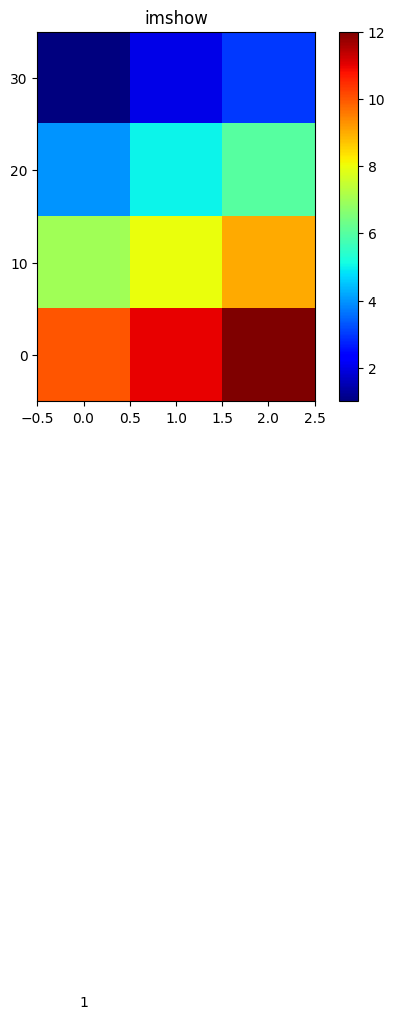

In [12]:
plt.imshow(testdata, cmap='jet')
plt.yticks([0, 1, 2, 3], [30, 20, 10, 0])
plt.text(0, 10, '1', ha='center', va='center')
plt.title('imshow')
plt.colorbar()
plt.show()

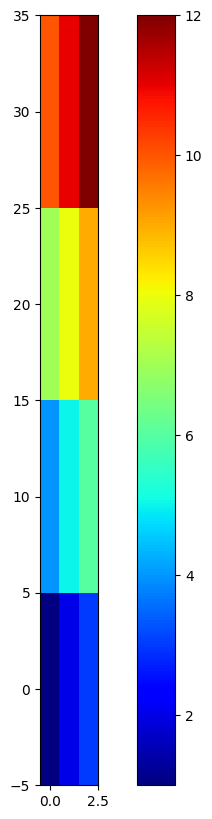

In [13]:
x = np.array([0,1,2])
y = np.array([0,10,20,30])
X, Y = np.meshgrid(x, y)
Z = testdata

# グラフ描画
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, aspect='equal')
contour = ax.pcolormesh(X, Y, Z, cmap='jet', shading='auto', norm=Normalize(vmin=Z.min(), vmax=Z.max()))
plt.colorbar(contour)
plt.show()


# プーリング層による平滑化

In [14]:
class poolingfilter(nn.Module):
    def __init__(self, kernel, padding) -> None:
        super().__init__()

        self.pool1 = nn.MaxPool2d(kernel_size=kernel, stride=1, padding=padding)

    def forward(self, x):
        x = self.pool1(x)
        return x

In [15]:
poolfilter = poolingfilter(kernel=(3,31), padding=(1,15))

torch.Size([1, 1, 16, 512])


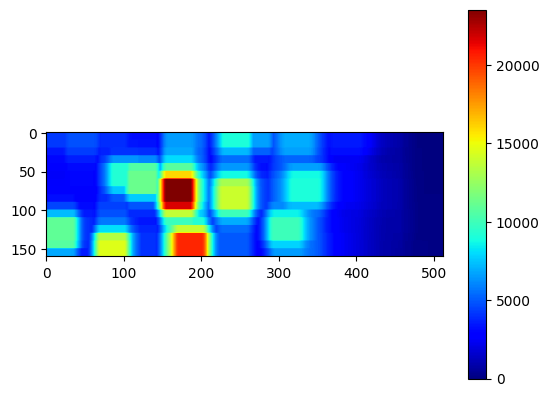

In [16]:
d1_datafiltered = poolfilter(d1_data.unsqueeze(0).unsqueeze(0))
print(d1_datafiltered.shape)
plot10x(d1_datafiltered.squeeze(0).squeeze(0))

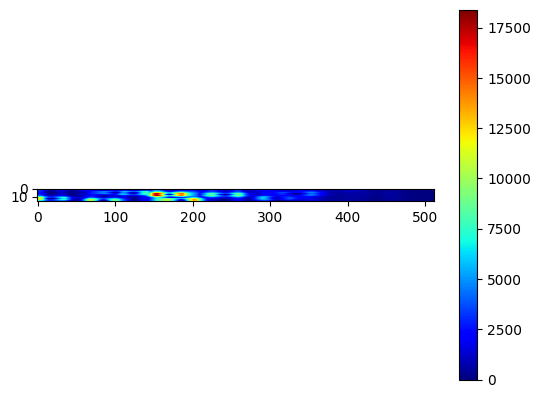

In [17]:
minused = d1_datafiltered - d1_data
plt.imshow(minused.squeeze(0).squeeze(0).detach().numpy(), cmap='jet')
plt.colorbar()
plt.show()

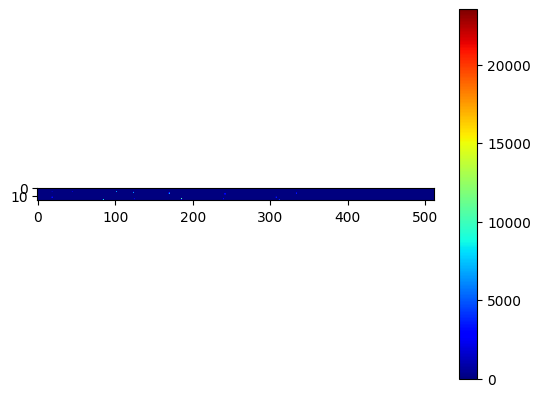

In [18]:
equal = torch.where(minused == 0.0, d1_data, 0.0)
plt.imshow(equal.squeeze(0).squeeze(0).detach().numpy(), cmap='jet')
plt.colorbar()
plt.show()

In [19]:
threshold = 7000

In [20]:
index = torch.where(equal > threshold)
indexcopy = copy.deepcopy(index)
index = []
for slice in indexcopy:
    slice = slice.tolist()
    index.append(slice)

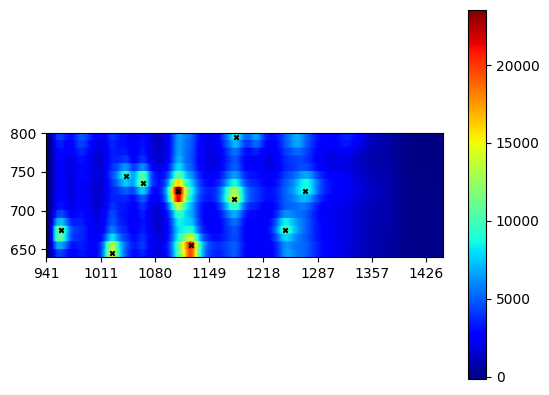

In [21]:
pltdata = []
for d in d1_data:
    for _ in range(10):
        pltdata.append(d)

plt.imshow(pltdata, cmap='jet')
plt.colorbar()

for i in range(len(index[0])):
    plt.scatter(index[3][i], index[2][i]*10+5, c='black', s=10, marker='x', label='found_peaks')
imgxtick=[i for i in range(len(pltdata[0]))]
plt.xticks(imgxtick[::70], myxticks[::70])
imgytick=[i for i in range(len(pltdata))]
imgytick = imgytick[::10]
plt.yticks(imgytick[::5], myyticks[::5])
plt.show()

In [22]:
def func(x, a, b):
    return a*x + b

In [23]:
print(imgytick)
print(myyticks)
print(index[2])

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
[800, 790, 780, 770, 760, 750, 740, 730, 720, 710, 700, 690, 680, 670, 660, 650]
[0, 5, 6, 7, 7, 8, 12, 12, 14, 15]


In [24]:
popt_x, _ = curve_fit(func, imgxtick, myxticks)
popt_y, _ = curve_fit(func, imgytick, myyticks)

In [25]:
for i in range(len(index[0])):
    peakx = func(index[3][i], *popt_x)
    peaky = func(index[2][i]*10, *popt_y)
    print(f'Peak at ({peakx}, {peaky})')

Peak at (1182.6115511759274, 800.0)
Peak at (1042.1577836056067, 750.0)
Peak at (1063.9182264686142, 740.0)
Peak at (1109.4173342730842, 730.0)
Peak at (1271.6315447064126, 730.0)
Peak at (1180.6333290974721, 720.0)
Peak at (960.0615673497151, 680.0)
Peak at (1245.9146576864946, 680.0)
Peak at (1125.2431109007262, 660.0)
Peak at (1025.3428959387375, 650.0)


In [26]:
fitdata = []
for i in range(len(index[0])):
    peakx = func(index[3][i], *popt_x)
    peaky = func(index[2][i]*10, *popt_y)

    nearestdistance = 10000000000
    nearestindex = None
    for j in range(len(chiraldata)):
        distance = np.sqrt((peakx - chiraldata[j][7])**2 + (peaky - chiraldata[j][8])**2)
        if distance < nearestdistance:
            nearestdistance = distance
            nearestindex = j
    
    fitdata.append([peakx, peaky, chiraldata[nearestindex][0], chiraldata[nearestindex][1], chiraldata[nearestindex][7], chiraldata[nearestindex][8]])
fitdata = np.array(fitdata)
print(fitdata)

[[1.18261155e+03 8.00000000e+02 1.20000000e+01 1.00000000e+00
  1.17091596e+03 7.96915167e+02]
 [1.04215778e+03 7.50000000e+02 1.00000000e+01 2.00000000e+00
  1.05352591e+03 7.34162226e+02]
 [1.06391823e+03 7.40000000e+02 1.00000000e+01 2.00000000e+00
  1.05352591e+03 7.34162226e+02]
 [1.10941733e+03 7.30000000e+02 9.00000000e+00 4.00000000e+00
  1.10124334e+03 7.20092915e+02]
 [1.27163154e+03 7.30000000e+02 8.00000000e+00 7.00000000e+00
  1.26659857e+03 7.28126835e+02]
 [1.18063333e+03 7.20000000e+02 8.00000000e+00 6.00000000e+00
  1.17202268e+03 7.15935335e+02]
 [9.60061567e+02 6.80000000e+02 8.00000000e+00 3.00000000e+00
  9.52380952e+02 6.63101604e+02]
 [1.24591466e+03 6.80000000e+02 9.00000000e+00 5.00000000e+00
  1.24373119e+03 6.70995671e+02]
 [1.12524311e+03 6.60000000e+02 7.00000000e+00 6.00000000e+00
  1.12217195e+03 6.47181628e+02]
 [1.02534290e+03 6.50000000e+02 7.00000000e+00 5.00000000e+00
  1.02310231e+03 6.44155844e+02]]


fitdata\
0 - foundpeakX\
1 - foundpeakY\
2 - NearestSWCNT_N\
3 - NearestSWCNT_M\
4 - NearestSWCNT_X\
5 - NearestSWCNT_Y\

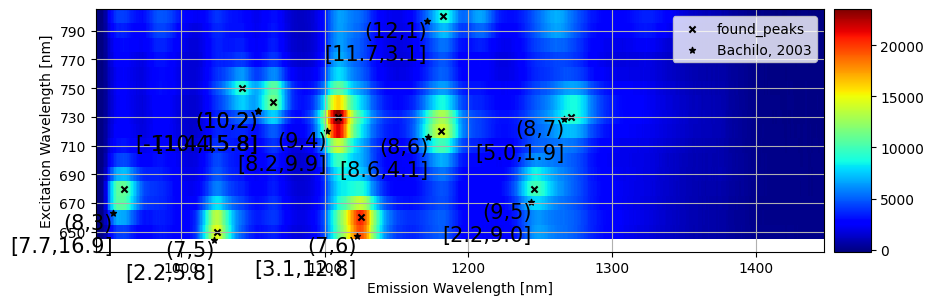

In [27]:
x = np.array(myxticks)
y = np.array(myyticks)
yticks = np.arange(650, 800 + 10, 10*2)
X, Y = np.meshgrid(x, y)
Z = np.array(d1_datal)

# グラフ描画
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, aspect='equal')
contour = ax.pcolormesh(X, Y, Z, cmap='jet', shading='auto', norm=Normalize(vmin=Z.min(), vmax=Z.max()))

# カラーバー調整用
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1)
pp = fig.colorbar(contour, cax=cax, orientation='vertical')

ax.set_yticks(yticks)
ax.set_xlabel('Emission Wavelength [nm]')
ax.set_ylabel('Excitation Wavelength [nm]')
ax.grid()

ax.scatter(fitdata[:,0], fitdata[:,1], c='black', s=20, marker='x', label='found_peaks')
ax.scatter(fitdata[:,4], fitdata[:,5], c='black', s=20, marker='*', label='Bachilo, 2003')
for ifitdata in fitdata:
    ax.text(ifitdata[4], ifitdata[5], f'({int(ifitdata[2])},{int(ifitdata[3])})\n[{ifitdata[0]-ifitdata[4]:.1f},{ifitdata[1]-ifitdata[5]:.1f}]', fontsize=15, ha='right', va='top')

ax.legend()

plt.show()

# 畳み込みフィルターを通したピーク検知

In [28]:
class ConvFilter(nn.Module):
    def __init__(self, kernel, padding) -> None:
        super().__init__()

        self.conv1 = nn.Conv2d(1, 1, kernel_size=kernel, stride=1, padding=padding)

    def forward(self, x):
        x = self.conv1(x)
        return x

In [29]:
convfilter = ConvFilter(kernel=(17,17), padding=(8,8))
convfilter.conv1.weight.data = torch.ones_like(convfilter.conv1.weight.data) / (17.0*17.0)
convfilter.conv1.bias.data = torch.zeros_like(convfilter.conv1.bias.data)

In [30]:
pltdata = np.array(pltdata)
pltdatatorch = torch.tensor(pltdata)
print(pltdata.shape)
print(d1_data.shape)

(160, 512)
torch.Size([16, 512])


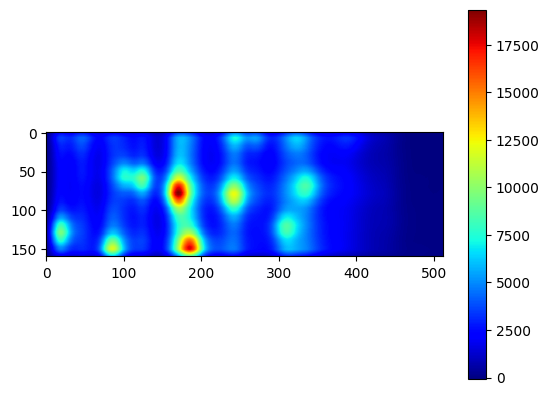

In [31]:
conved = convfilter(pltdatatorch.unsqueeze(0).unsqueeze(0))
plt.imshow(conved.squeeze(0).squeeze(0).detach().numpy(), cmap='jet')
plt.colorbar()
plt.show()

In [32]:
poolfilter2 = poolingfilter(kernel=(5,5), padding=(2,2))

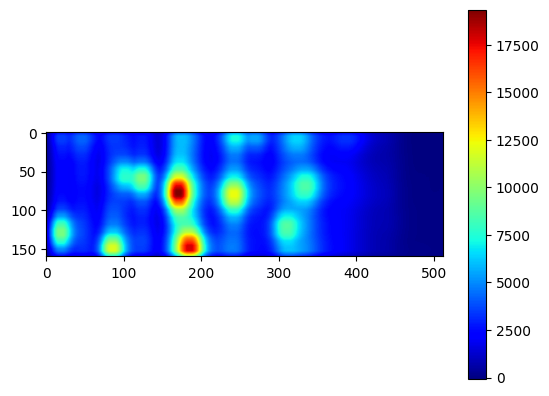

In [33]:
pooled_conved = poolfilter2(conved)
plt.imshow(pooled_conved.squeeze(0).squeeze(0).detach().numpy(), cmap='jet')
plt.colorbar()
plt.show()

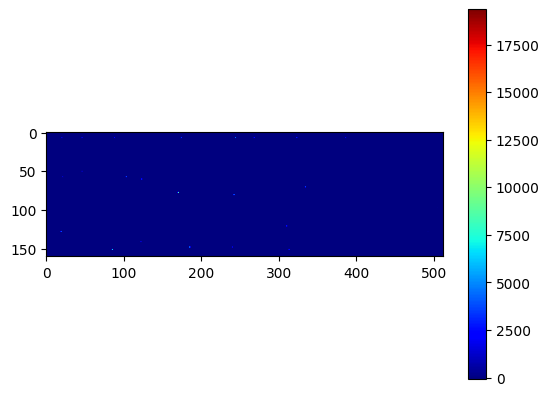

In [34]:
minused_conved = pooled_conved - conved
minused_conved = torch.where(minused_conved == 0.0, conved, 0.0)
plt.imshow(minused_conved.squeeze(0).squeeze(0).detach().numpy(), cmap='jet')
plt.colorbar()
plt.show()

In [35]:
threshold = 7000

In [36]:
index = torch.where(minused_conved > threshold)
indexcopy = copy.deepcopy(index)
index = []
for slice in indexcopy:
    slice = slice.tolist()
    index.append(slice)
index = np.array(index)
print(index)

[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  8  58  61  71  78  81 121 128 148 151]
 [244 103 123 334 170 242 310  19 185  85]]


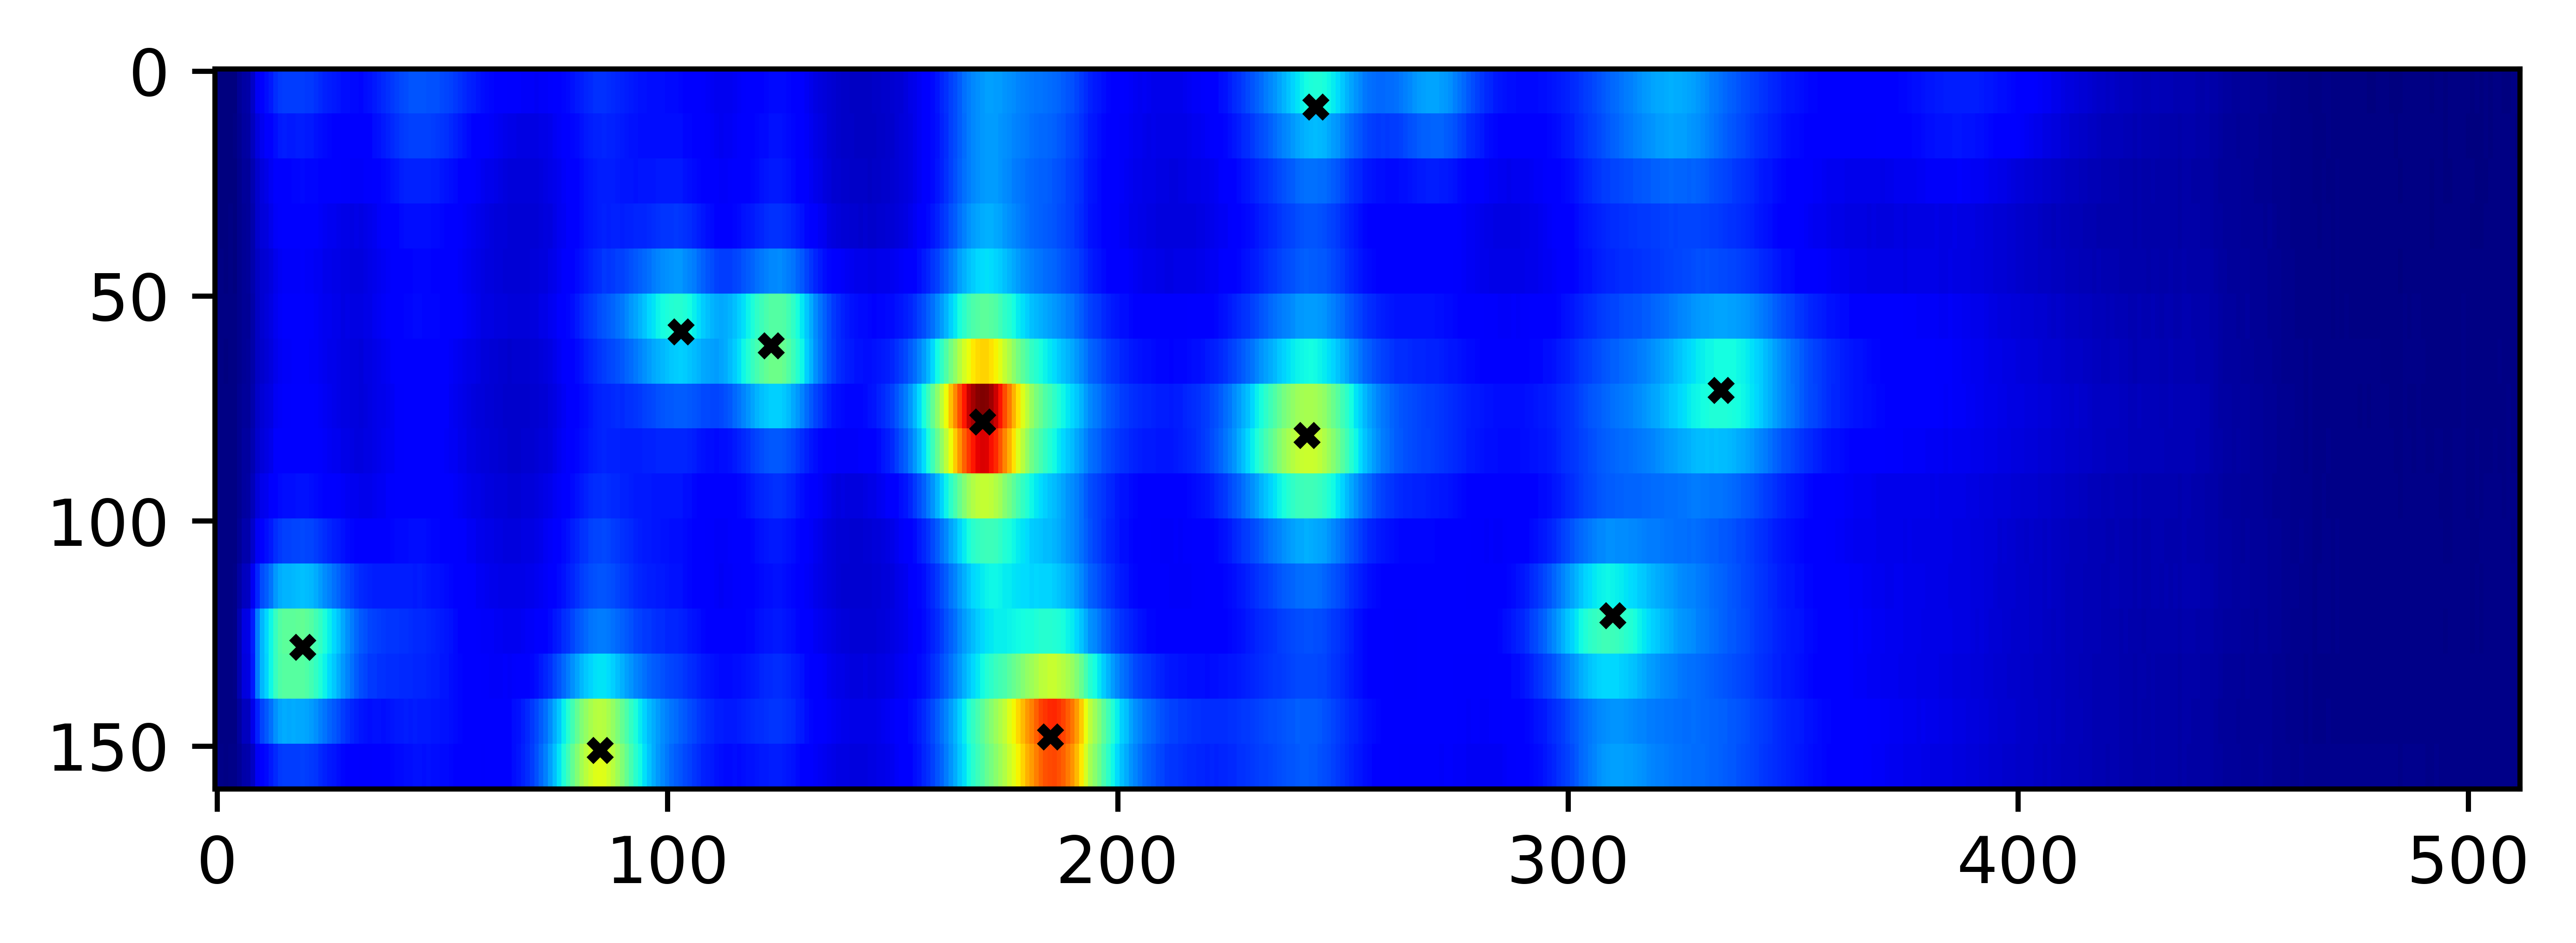

In [37]:
fig = plt.figure(dpi=1000)
plt.imshow(pltdata, cmap='jet')
plt.scatter(index[3,:], index[2,:], c='black', s=10, marker='x', label='found_peaks')
plt.show()

In [38]:
print(pltdata.shape)
print(myxticks)
print(myyticks)
popt_x, _ = curve_fit(func, [0, pltdata.shape[1]-1], [myxticks[0], myxticks[-1]])
popt_y, _ = curve_fit(func, [0, pltdata.shape[0]-1], [myyticks[0]+5, myyticks[-1]-5])

(160, 512)
[941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 111

C:\Users\kouga\AppData\Local\Temp\ipykernel_3672\4166733967.py:4: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_x, _ = curve_fit(func, [0, pltdata.shape[1]-1], [myxticks[0], myxticks[-1]])
C:\Users\kouga\AppData\Local\Temp\ipykernel_3672\4166733967.py:5: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_y, _ = curve_fit(func, [0, pltdata.shape[0]-1], [myyticks[0]+5, myyticks[-1]-5])


In [39]:
for i in range(len(index[0])):
    peakx = func(index[3][i], *popt_x)
    peaky = func(index[2][i], *popt_y)
    print(f'Peak at ({peakx}, {peaky})')

Peak at (1182.6125244618395, 796.9496855345911)
Peak at (1042.9921722113504, 746.6352201257862)
Peak at (1062.7964774951076, 743.6163522012579)
Peak at (1271.7318982387476, 733.5534591194969)
Peak at (1109.3365949119375, 726.5094339622642)
Peak at (1180.6320939334637, 723.4905660377358)
Peak at (1247.9667318982388, 683.2389937106918)
Peak at (959.8140900195694, 676.1949685534591)
Peak at (1124.1898238747553, 656.0691823899372)
Peak at (1025.1682974559687, 653.0503144654087)


In [40]:
fitdata = []
for i in range(len(index[0])):
    peakx = func(index[3][i], *popt_x)
    peaky = func(index[2][i], *popt_y)

    nearestdistance = 10000000000
    nearestindex = None
    for j in range(len(chiraldata)):
        distance = np.sqrt((peakx - chiraldata[j][7])**2 + (peaky - chiraldata[j][8])**2)
        if distance < nearestdistance:
            nearestdistance = distance
            nearestindex = j
    
    fitdata.append([peakx, peaky, chiraldata[nearestindex][0], chiraldata[nearestindex][1], chiraldata[nearestindex][7], chiraldata[nearestindex][8]])
fitdata = np.array(fitdata)
print(fitdata)

[[1.18261252e+03 7.96949686e+02 1.20000000e+01 1.00000000e+00
  1.17091596e+03 7.96915167e+02]
 [1.04299217e+03 7.46635220e+02 1.00000000e+01 2.00000000e+00
  1.05352591e+03 7.34162226e+02]
 [1.06279648e+03 7.43616352e+02 1.00000000e+01 2.00000000e+00
  1.05352591e+03 7.34162226e+02]
 [1.27173190e+03 7.33553459e+02 8.00000000e+00 7.00000000e+00
  1.26659857e+03 7.28126835e+02]
 [1.10933659e+03 7.26509434e+02 9.00000000e+00 4.00000000e+00
  1.10124334e+03 7.20092915e+02]
 [1.18063209e+03 7.23490566e+02 8.00000000e+00 6.00000000e+00
  1.17202268e+03 7.15935335e+02]
 [1.24796673e+03 6.83238994e+02 9.00000000e+00 5.00000000e+00
  1.24373119e+03 6.70995671e+02]
 [9.59814090e+02 6.76194969e+02 8.00000000e+00 3.00000000e+00
  9.52380952e+02 6.63101604e+02]
 [1.12418982e+03 6.56069182e+02 7.00000000e+00 6.00000000e+00
  1.12217195e+03 6.47181628e+02]
 [1.02516830e+03 6.53050314e+02 7.00000000e+00 5.00000000e+00
  1.02310231e+03 6.44155844e+02]]


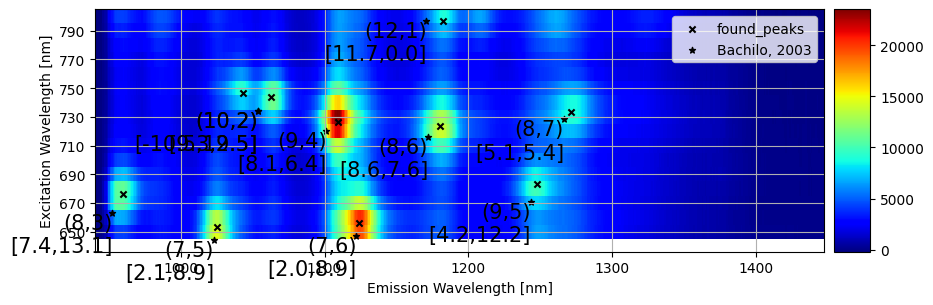

In [41]:
x = np.array(myxticks)
y = np.array(myyticks)
yticks = np.arange(650, 800 + 10, 10*2)
X, Y = np.meshgrid(x, y)
Z = np.array(d1_datal)

# グラフ描画
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, aspect='equal')
contour = ax.pcolormesh(X, Y, Z, cmap='jet', shading='auto', norm=Normalize(vmin=Z.min(), vmax=Z.max()))

# カラーバー調整用
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1)
pp = fig.colorbar(contour, cax=cax, orientation='vertical')

ax.set_yticks(yticks)
ax.set_xlabel('Emission Wavelength [nm]')
ax.set_ylabel('Excitation Wavelength [nm]')
ax.grid()

ax.scatter(fitdata[:,0], fitdata[:,1], c='black', s=20, marker='x', label='found_peaks')
ax.scatter(fitdata[:,4], fitdata[:,5], c='black', s=20, marker='*', label='Bachilo, 2003')
for ifitdata in fitdata:
    ax.text(ifitdata[4], ifitdata[5], f'({int(ifitdata[2])},{int(ifitdata[3])})\n[{ifitdata[0]-ifitdata[4]:.1f},{ifitdata[1]-ifitdata[5]:.1f}]', fontsize=15, ha='right', va='top')

ax.legend()

plt.show()